# UNET

### Importamos todas las instancias necesarias 📚 📦

In [1]:
# Bibliotecas estándar de Python
import os
import datetime
import random

# Bibliotecas para manipulación de datos y visualización
import numpy as np
import matplotlib.pyplot as plt

# Bibliotecas de procesamiento de imágenes
from PIL import Image
import PIL

# PyTorch y sus submódulos
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T

Freezing and Thawing Layers and Parameters

### GPU ⚙️ 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device} está disponible")

cuda está disponible


### Transformaciones

In [3]:
transform_data = T.Compose([
                    T.Resize((224, 224)),               # Redimensionar a 224x224 píxeles
                    T.ToTensor(),                       # Convertir a tensor de PyTorch                    
])

### Dataset and Dataloader 💾

In [4]:
# Ruta base (directorio actual donde se encuentra este notebook)
PATH = os.path.dirname(os.path.abspath('__file__'))  # Directorio actual

# Rutas específicas para los datos
TRAIN_PATH = os.path.join(PATH, 'data/train/')
TRAIN_MASKS_PATH = os.path.join(PATH, 'data/train_masks/')
TEST_PATH = os.path.join(PATH, 'data/test/')

#### DataSet

In [5]:
from helpers import Car_Dataset

# Datos de Entrenamiento y Validación
full_dataset = Car_Dataset(TRAIN_PATH,
                          TRAIN_MASKS_PATH,
                          imgs_transform=transform_data,
                          mask_transform=transform_data)

BATCH_SIZE = 32
TRAIN_SIZE = int(len(full_dataset) * 0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE

train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE]) # Cargamos nuestros datasets de manera aleatoria

# Datos de Prueba
test_set = Car_Dataset(TEST_PATH,
                       imgs_transform=transform_data,
                       mask_transform=transform_data)

#### DataLoaders

In [6]:
from helpers import Car_Dataset

# Datos de Entrenamiento y Validación
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=True)

# Datos de Prueba
test_loader = DataLoader(test_set, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

In [7]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


***torch.Size([32, 3, 224, 224])*** --> Tensores de 4 dimensiones:
> 32: Tamaño del batch (número de imágenes procesadas a la vez)

> 3: Número de canales de color (RGB - Rojo, Verde, Azul)

>224: Altura de cada imagen en píxeles

>224: Anchura de cada imagen en píxeles

### Visualización de datos

In [9]:
# Imprimimos una muestras de las dimensiones de las imágenes y máscaras
# de esta manera podemos verificar que las dimensiones son correctas y coinciden entre imágenes y máscaras
for i, (x, y) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"  Imágenes: {x.shape}")
    print(f"  Máscaras: {y.shape}")
    if i == 3: break

Batch 1:
  Imágenes: torch.Size([32, 3, 224, 224])
  Máscaras: torch.Size([32, 1, 224, 224])
Batch 2:
  Imágenes: torch.Size([32, 3, 224, 224])
  Máscaras: torch.Size([32, 1, 224, 224])
Batch 3:
  Imágenes: torch.Size([32, 3, 224, 224])
  Máscaras: torch.Size([32, 1, 224, 224])
Batch 4:
  Imágenes: torch.Size([32, 3, 224, 224])
  Máscaras: torch.Size([32, 1, 224, 224])


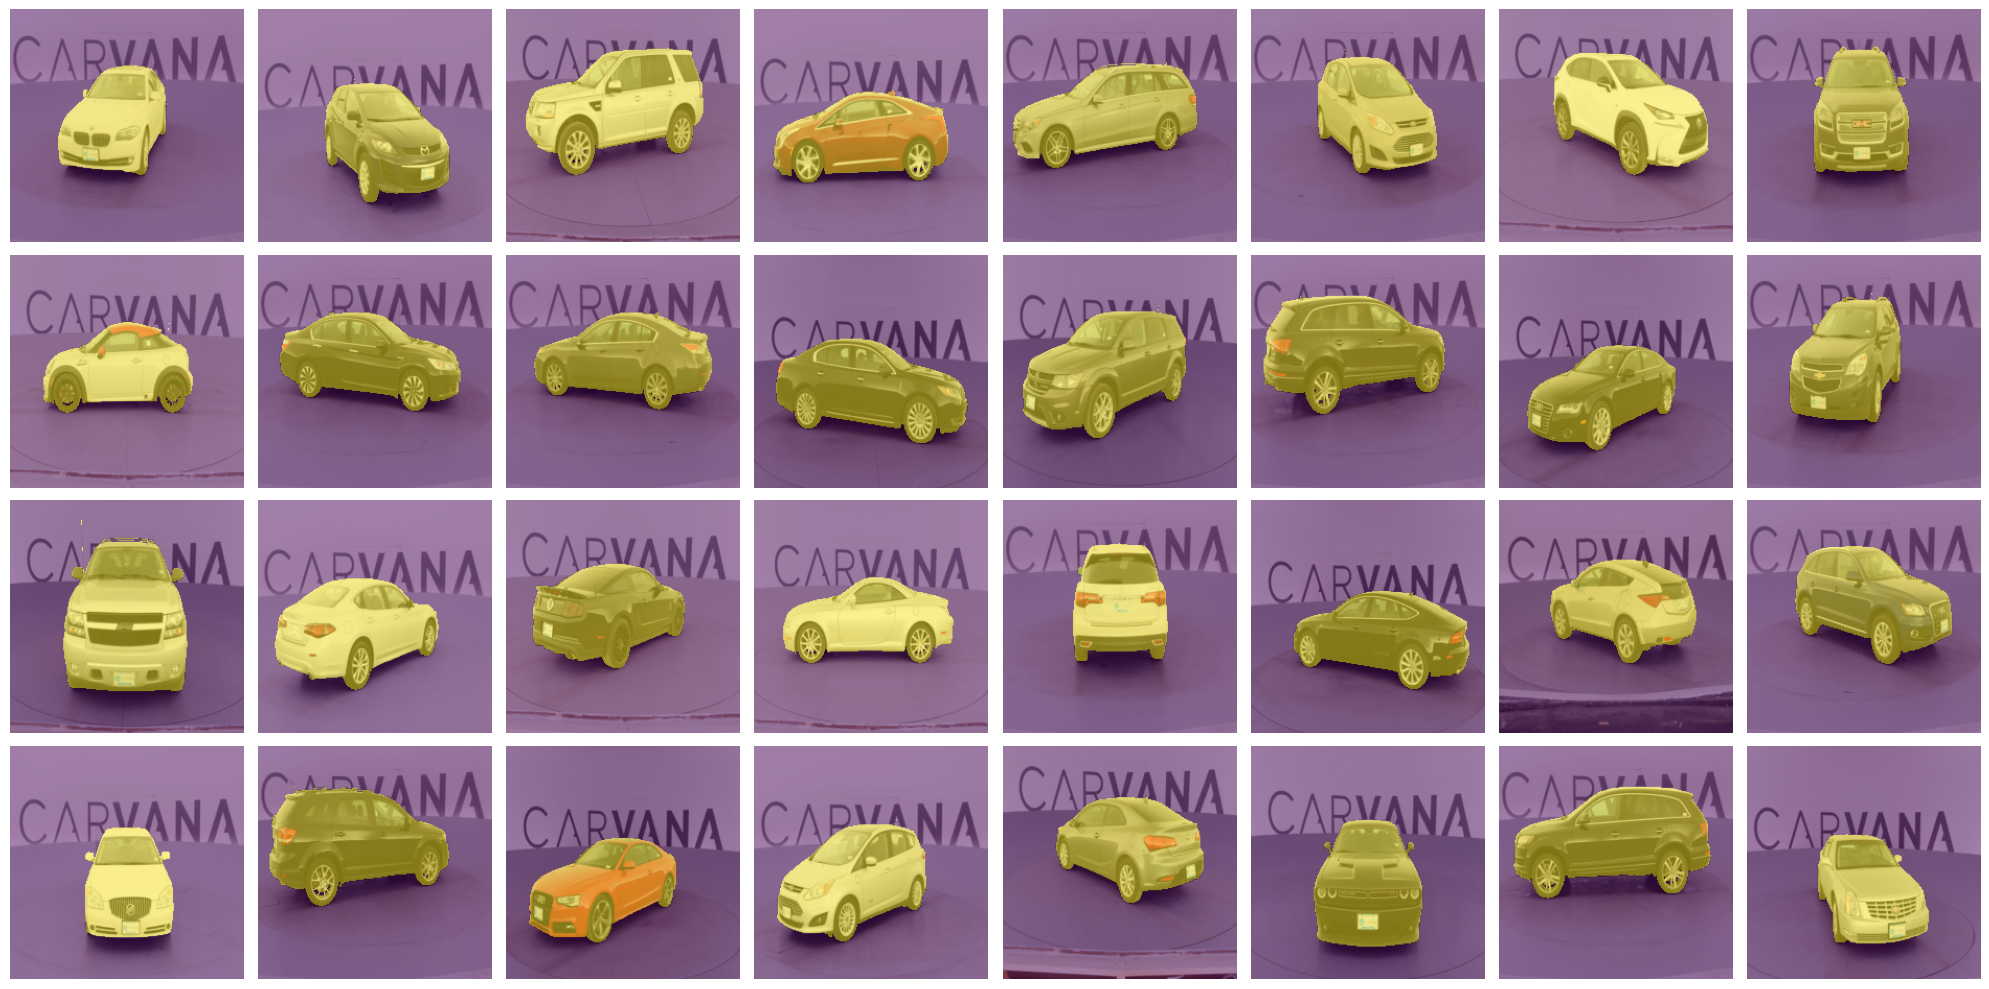

In [ ]:
from helpers import plot_mini_batch

# Imprimimos una muestra de imágenes y máscaras de manera superpuesta
# de esta manera podemos verificar que se están cargando correctamente y coinciden
imgs, masks = next(iter(train_loader))

# Imprimimos una muestra de imágenes y máscaras de manera superpuesta
# de esta manera podemos verificar que se están cargando correctamente y coinciden
plot_mini_batch(imgs, masks)

### Modelo U-NET

![Arquitectura U-NET](imagenes/UNET_arquitectura.png)

#### Componentes del Encoder en U-NET
##### Primera capa de contracción:
- Dos convoluciones 3×3 (con activación ReLU)
- Un max pooling 2×2 (stride 2) para reducir la resolución a la mitad
##### Segunda capa de contracción:
- Dos convoluciones 3×3 (con activación ReLU)
- Un max pooling 2×2 (stride 2) para reducir la resolución nuevamente
##### Tercera capa de contracción:
- Dos convoluciones 3×3 (con activación ReLU)
- Un max pooling 2×2 (stride 2) para reducir la resolución
##### Cuarta capa de contracción:
- Dos convoluciones 3×3 (con activación ReLU)
- Un max pooling 2×2 (stride 2) para reducir la resolución
##### Capa inferior (fondo de la "U"):
- Dos convoluciones 3×3 (con activación ReLU)

> En cada nivel del encoder, el número de filtros (canales) se duplica después de cada max pooling, iniciando típicamente con 64 filtros en la primera capa y llegando a 1024 en la capa inferior.

Para ver el detalle de su construcción, véase `helpers.py`

![Arquitectura U-NET](imagenes/UNET_arquitectura_2.png)

A continuación podemos verificar que las dimensiones de nuestra implementación funciona.
Debería arrojarnos un tensor de salida (32, 2, 224, 224)

In [18]:
from helpers import U_NET

def test():
    x = torch.randn((32, 3, 224, 224))  # Batch de 32 imágenes de 3 canales (RGB) y tamaño 224x224
    model = U_NET(3, 64, 2)  # Definimos el modelo U-Net
    return model(x)

prediction = test()
print("Predicción:", prediction.shape)  # Debería ser (32, 2, 224, 224) para 2 clases

Predicción: torch.Size([32, 2, 224, 224])


### Entrenamiento del modelo

#### Buscamos el learning rate óptimo de partida

cost:0.7899, lr: 0.0000, acc: 0.1993
cost:0.8015, lr: 0.0000, acc: 0.1889
cost:0.7961, lr: 0.0000, acc: 0.1960
cost:0.7882, lr: 0.0000, acc: 0.2031
cost:0.7997, lr: 0.0000, acc: 0.1970
cost:0.7933, lr: 0.0000, acc: 0.1998
cost:0.8023, lr: 0.0000, acc: 0.1933
cost:0.7914, lr: 0.0000, acc: 0.2052
cost:0.7969, lr: 0.0000, acc: 0.1982
cost:0.7946, lr: 0.0000, acc: 0.1969
cost:0.8001, lr: 0.0000, acc: 0.1946
cost:0.7974, lr: 0.0000, acc: 0.1944
cost:0.7938, lr: 0.0000, acc: 0.1945
cost:0.7994, lr: 0.0000, acc: 0.1933
cost:0.7960, lr: 0.0000, acc: 0.1990
cost:0.8021, lr: 0.0000, acc: 0.1897
cost:0.7979, lr: 0.0000, acc: 0.1943
cost:0.7950, lr: 0.0000, acc: 0.1999
cost:0.7912, lr: 0.0000, acc: 0.2042
cost:0.8034, lr: 0.0000, acc: 0.1868
cost:0.7963, lr: 0.0000, acc: 0.1947
cost:0.7957, lr: 0.0000, acc: 0.1992
cost:0.7878, lr: 0.0000, acc: 0.2052
cost:0.7913, lr: 0.0000, acc: 0.1982
cost:0.7934, lr: 0.0000, acc: 0.2022
cost:0.7919, lr: 0.0000, acc: 0.1968
cost:0.7931, lr: 0.0000, acc: 0.1959
c

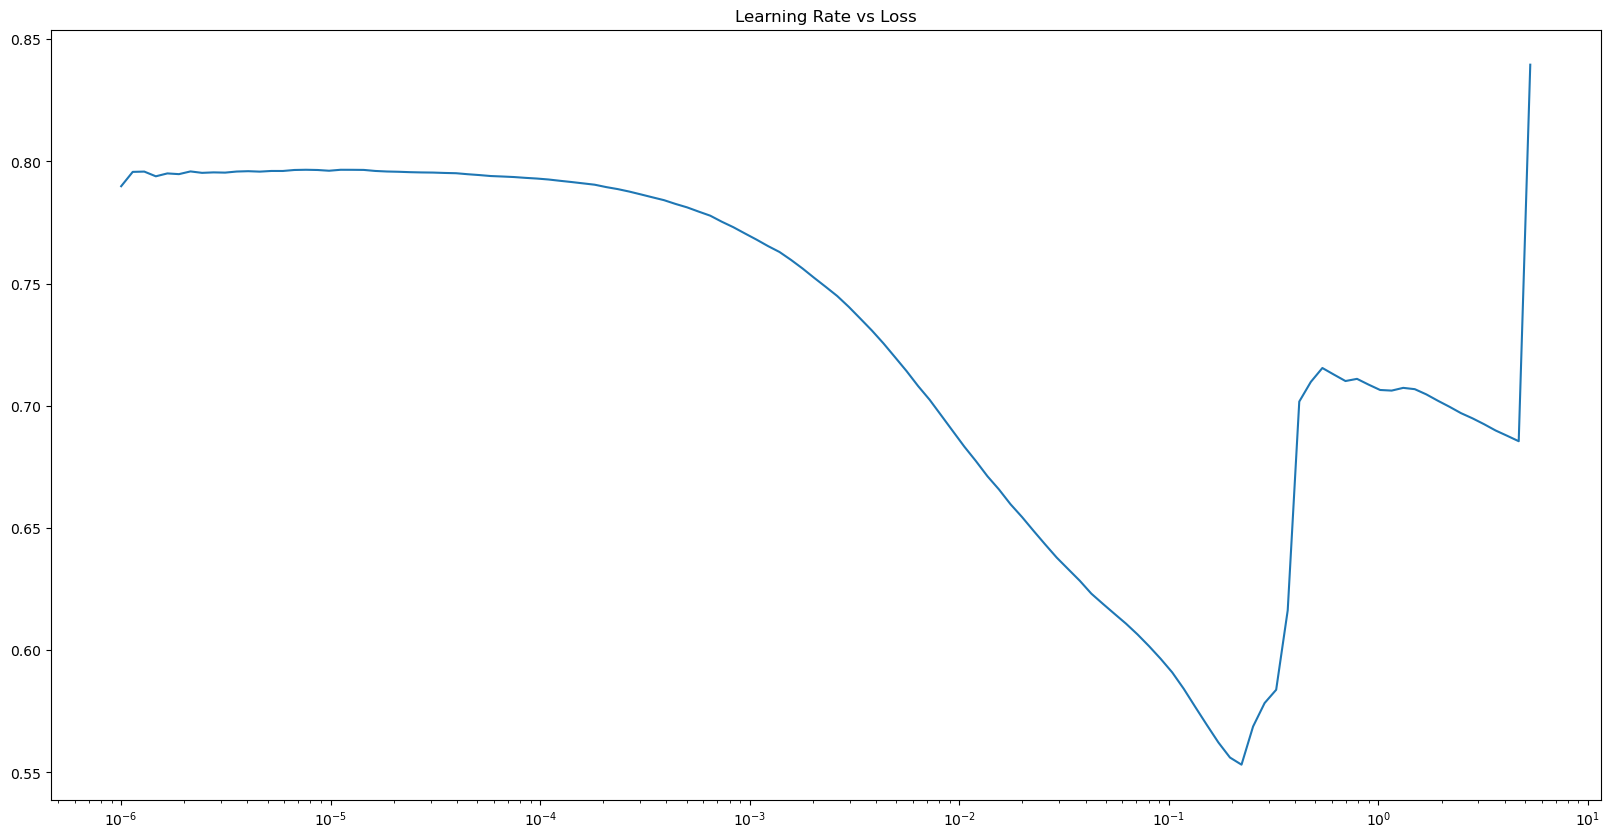

In [19]:
from helpers import U_NET, find_lr

torch.manual_seed(42)
model = U_NET(3,4,2)
optimizer = torch.optim.SGD(model.parameters(), 
                           lr=1e-2, 
                           momentum=0.95, 
                           weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(device, 
                                    model, 
                                    optimizer, 
                                    start_val=1e-6, 
                                    end_val=10,
                                    train_loader=train_loader)

# Mostramos los valores de loss y learnin rate
f1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.title('Learning Rate vs Loss')
plt.show()

In [ ]:
from helpers import U_NET

# Definimos el optimizador y el scheduler
learning_rate = 0.05
epochs = 1
torch.manual_seed(42)
model = U_NET(3,64,2)
optimizer = torch.optim.SGD(model.parameters(), 
                           lr=learning_rate, 
                           momentum=0.95, 
                           weight_decay=1e-4)

total_steps = len(train_loader) * epochs            # Calcular el número total de pasos

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.1, 
                                                total_steps=total_steps)

### Graficamos las imágenes con las predicciones del modelo

torch.Size([32, 224, 224])


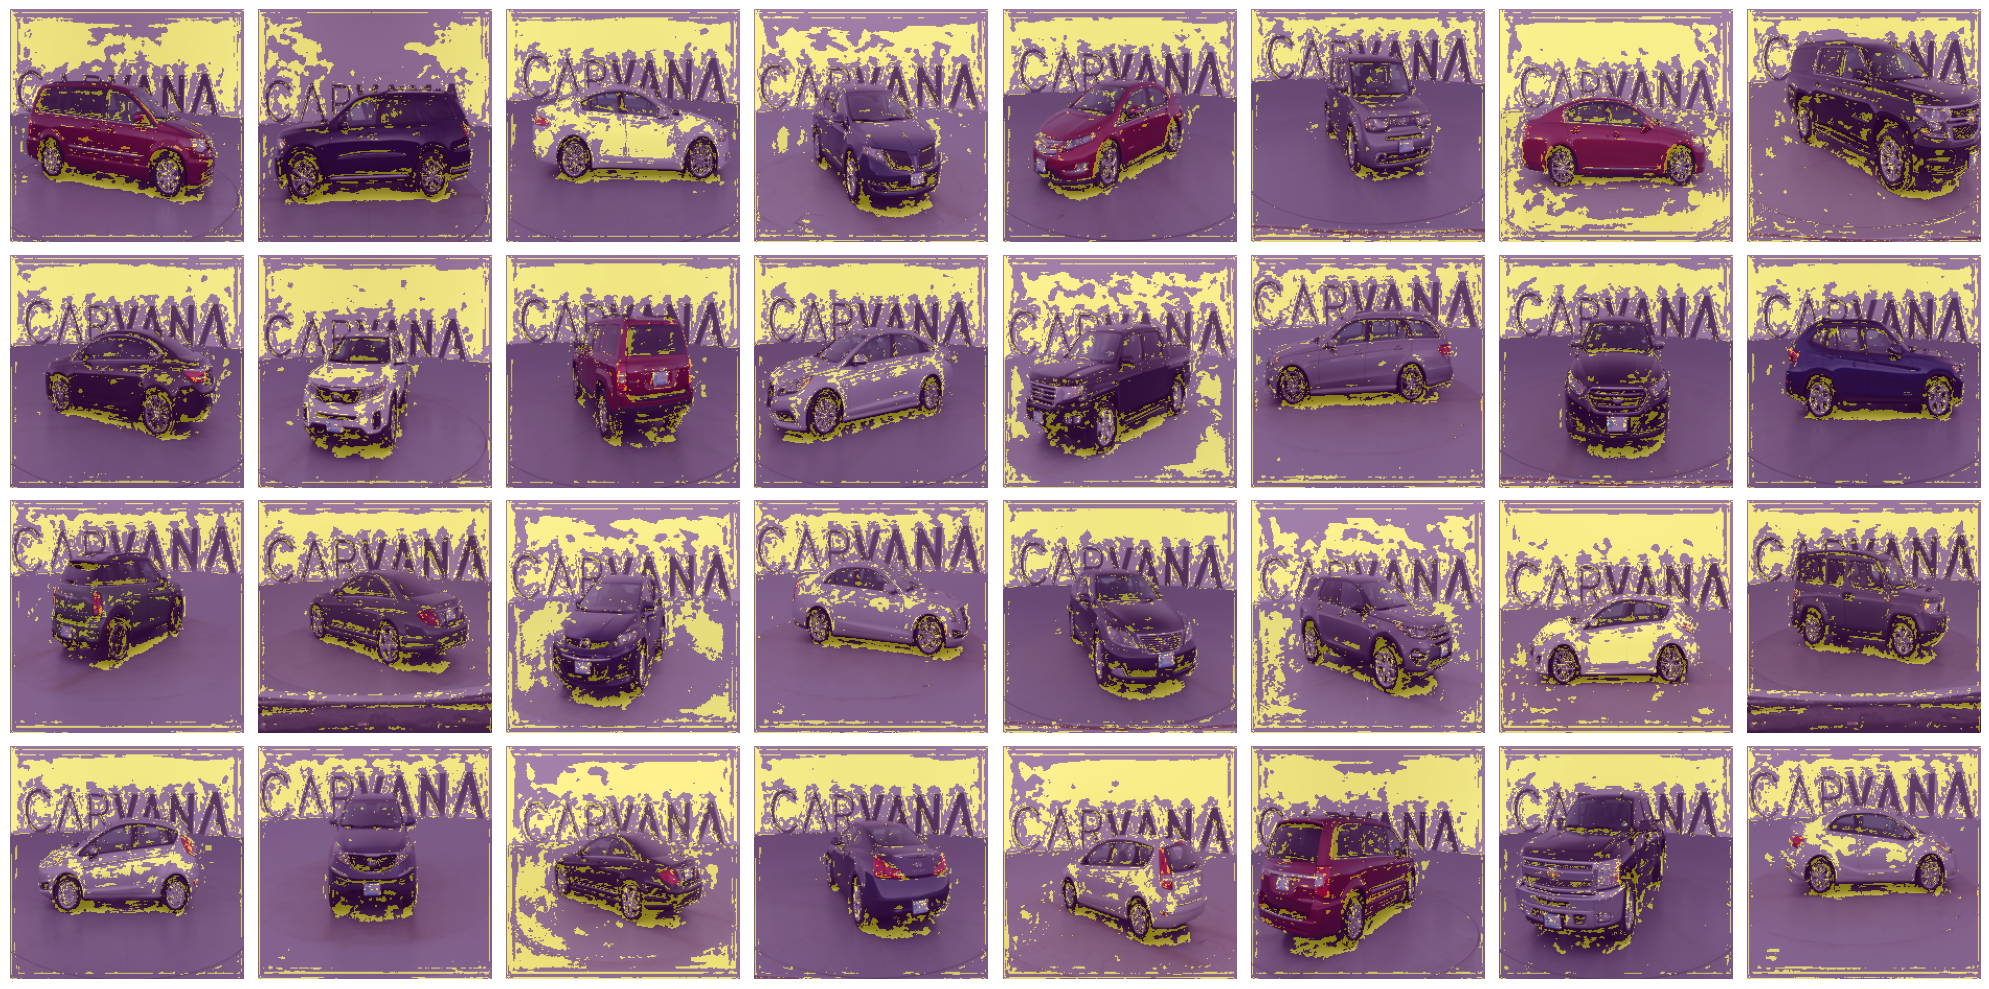

In [21]:
from helpers import plot_mini_batch

# Obtener un batch de imágenes y máscaras del val_loader
imgs_val, masks_val = next(iter(val_loader))

# Convertir las imágenes y máscaras al dispositivo adecuado
imgs_val = imgs_val.to(device, dtype=torch.float32)
masks_val = masks_val.to(device, dtype=torch.long)

# Convertir el modelo al dispositivo adecuado
model = model.to(device)

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()
    
imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1), BATCH_SIZE=BATCH_SIZE)

In [ ]:
from helpers import train

time_train, epochs, dice, iou = train(device, model, optimizer, scheduler, epochs=epochs, store_every=25, train_loader=train_loader, val_loader=val_loader)

print(f"Tiempo de entrenamiento: {time_train}")
print(f"En un total de {epochs} épocas.")
print(f"Dice: {dice*100:.2f} %")
print(f"IoU: {iou*100:.2f} %")

Modelo en dispositivo: cuda:0
Epoch 1/1, Batch 25, Train Cost: 0.2236, Train Accuracy: 0.9172, Validation Cost: 1.1784, Validation Accuracy: 0.8628, DICE: 0.5656, IoU: 0.3957
Epoch 1/1, Batch 50, Train Cost: 0.1354, Train Accuracy: 0.9493, Validation Cost: 0.1331, Validation Accuracy: 0.9616, DICE: 0.9007, IoU: 0.8196
Epoch 1/1, Batch 75, Train Cost: 0.0992, Train Accuracy: 0.9625, Validation Cost: 0.0347, Validation Accuracy: 0.9867, DICE: 0.9682, IoU: 0.9385
Epoch 1/1, Batch 100, Train Cost: 0.0803, Train Accuracy: 0.9696, Validation Cost: 0.0228, Validation Accuracy: 0.9908, DICE: 0.9783, IoU: 0.9575
Epoch 1/1, Batch 125, Train Cost: 0.0684, Train Accuracy: 0.9740, Validation Cost: 0.0200, Validation Accuracy: 0.9920, DICE: 0.9811, IoU: 0.9630
Tiempo de entrenamiento: 00:03:51 


### Guardamos el modelo 💾

In [31]:
os.makedirs('models', exist_ok=True)        # Crear el directorio 'models' si no existe

model_name = f'U-NET_dice({dice:.2f})_IoU({iou:.2f})_epoch({epochs})'

# Guardar el modelo completo con nombre descriptivo
torch.save(model, f'models/{model_name}.pth')
print(f"Modelo completo guardado en 'models/{model_name}.pth'")

Modelo completo guardado en 'models/U-NET_dice(0.98)_IoU(0.96)_epoch(1).pth'


### Evaluamos nuestro modelo ⚖️📊

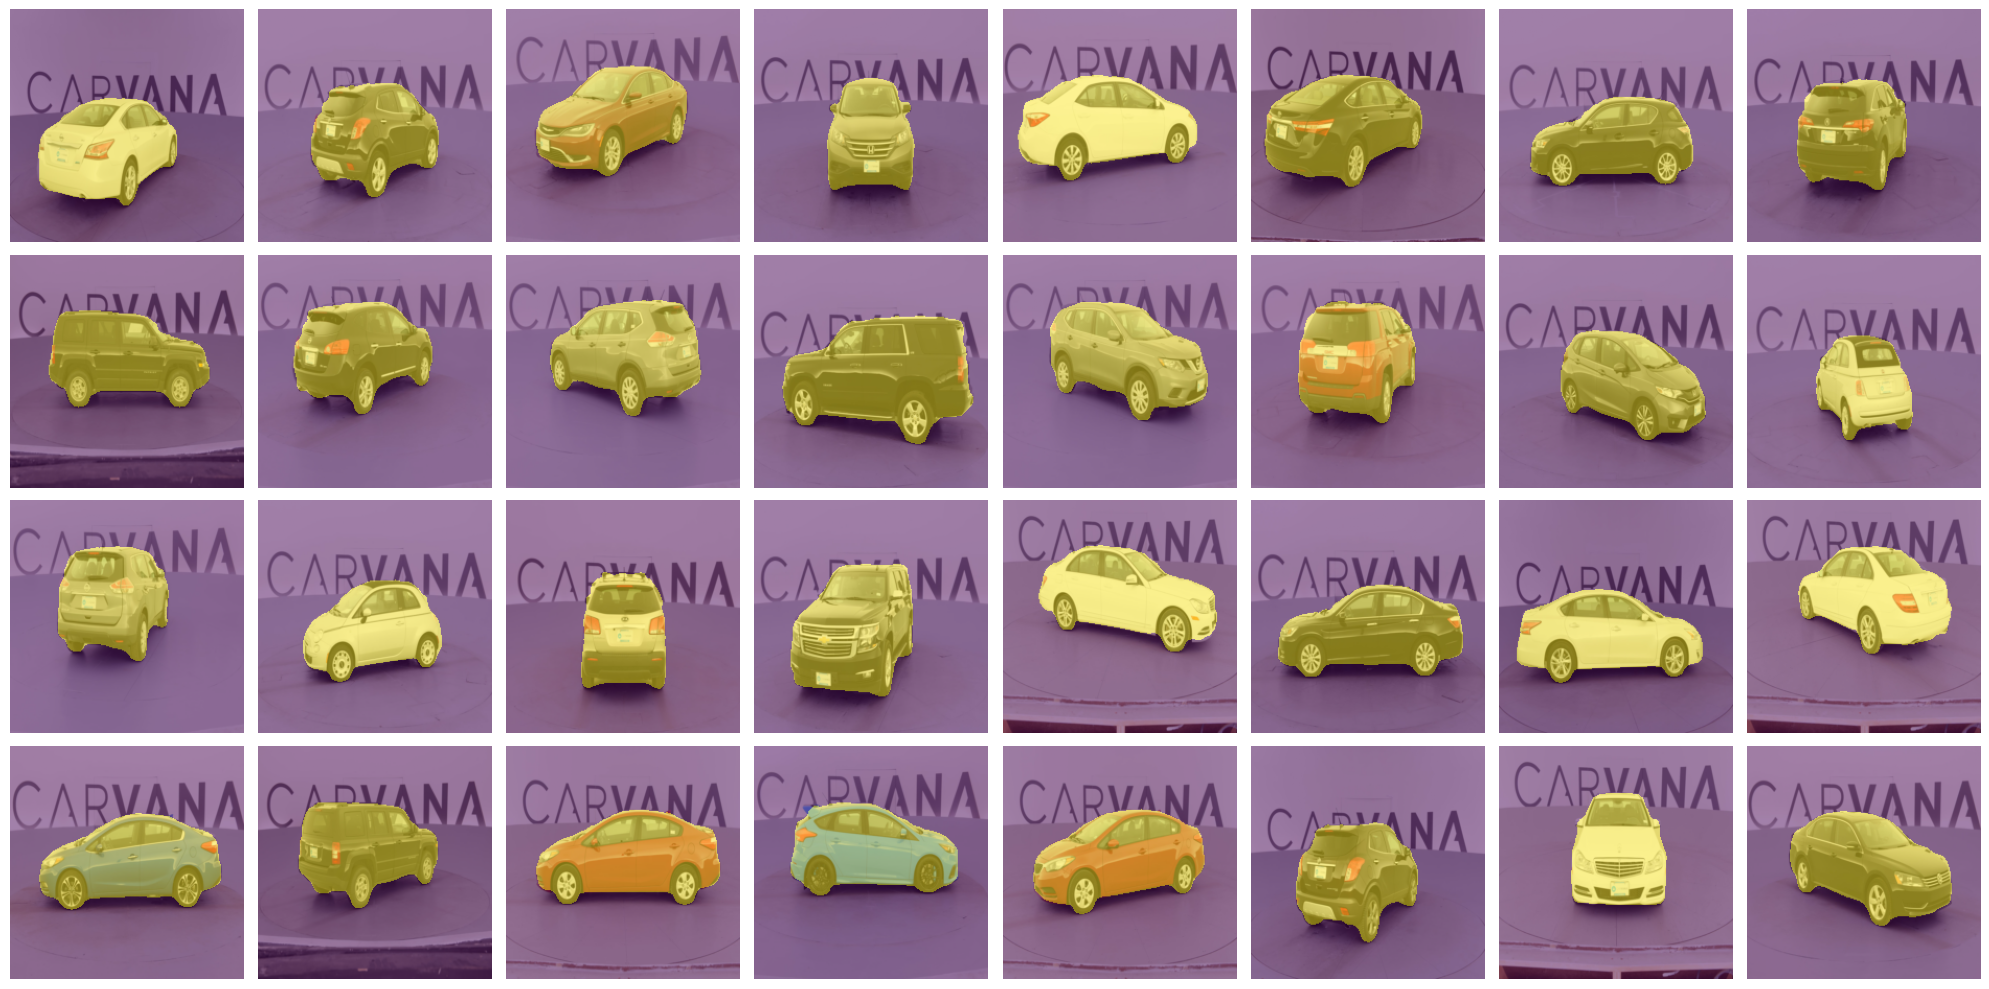

In [37]:
from helpers import Car_Dataset, plot_mini_batch

# Obtener un batch de imágenes y máscaras del test_loader
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)

# Cargamos el modelo guardado con weights_only=False
model = torch.load(f'models/{model_name}.pth', weights_only=False)
model.eval()  # Poner el modelo en modo evaluación
model = model.to(device)

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()
    
imgs_test = imgs_test.cpu()
preds = preds.cpu()
plot_mini_batch(imgs_test, preds.unsqueeze(1))